In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [3]:
df = pd.read_csv('dataset/heart_failure.csv')
X = df.drop(columns=['DEATH_EVENT'], axis=1)
y = df['DEATH_EVENT']

In [4]:
X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [5]:
y.value_counts()

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

## Pre procesamento

In [6]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

## Split Train-Test

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43) 

In [9]:
train_index = X_train.columns
train_index

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')

In [10]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = train_index
mutual_info.sort_values(ascending=False)

time                        0.237912
ejection_fraction           0.096351
age                         0.069128
high_blood_pressure         0.034687
serum_creatinine            0.022869
anaemia                     0.009605
creatinine_phosphokinase    0.009127
sex                         0.008980
diabetes                    0.005792
platelets                   0.000000
serum_sodium                0.000000
smoking                     0.000000
dtype: float64

<Axes: >

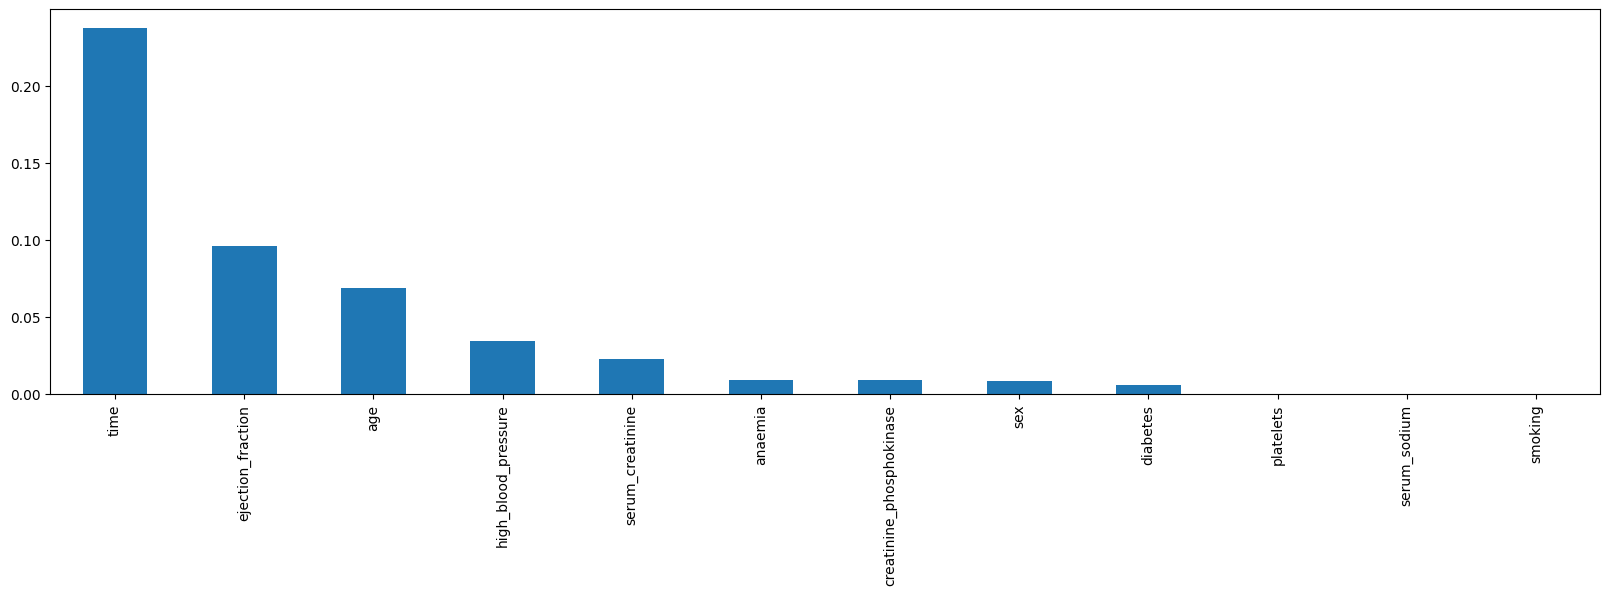

In [11]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 5))

In [12]:
from sklearn.feature_selection import SelectKBest
Select_features = SelectKBest(mutual_info_classif, k=7)
Select_features.fit(X_train, y_train)
train_index[Select_features.get_support()]

Index(['age', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction',
       'serum_creatinine', 'sex', 'time'],
      dtype='object')

In [13]:
columns = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
       'high_blood_pressure', 'serum_creatinine', 'smoking', 'time']

X_train=X_train[columns]
X_test=X_test[columns]

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy')

In [18]:
grid.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))


In [ ]:
eval_metric(grid, X_train, y_train, X_test, y_test)

Test_Set
[[30  4]
 [ 6 20]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        34
           1       0.83      0.77      0.80        26

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60


Train_Set
[[162   7]
 [ 19  51]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       169
           1       0.88      0.73      0.80        70

    accuracy                           0.89       239
   macro avg       0.89      0.84      0.86       239
weighted avg       0.89      0.89      0.89       239

